# Task
Analyze the `train.csv` dataset from Google Drive, build a logistic regression model to predict the winning team of a basketball match, evaluate its performance, and create an interactive user interface for making predictions to inform March Madness bracket selections.

## Load Dataset

### Subtask:
Load the `train.csv` dataset from your Google Drive into a pandas DataFrame.


**Reasoning**:
First, I'll mount Google Drive to access the files, then import the pandas library. After that, I'll specify the path to the `train.csv` file and load it into a pandas DataFrame. Finally, I'll display the first few rows to verify the data was loaded correctly.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Specify the path to your train.csv file in Google Drive
# This example assumes the file is in the root of your Google Drive
# If it's in a subfolder, adjust the path accordingly, e.g., '/content/drive/MyDrive/my_data/train.csv'
file_path = '/content/drive/MyDrive/Sports Analytics/train.csv'

# Load the dataset into a pandas DataFrame
try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully from {file_path}.")
    # Display the first 5 rows of the DataFrame
    print("First 5 rows of the DataFrame:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the path and ensure the file exists in your Google Drive.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Mounted at /content/drive
Dataset loaded successfully from /content/drive/MyDrive/Sports Analytics/train.csv.
First 5 rows of the DataFrame:
               ID  Season  Team1  Team2     Type Gender  \
0  1985_1228_1328    1985   1228   1328  regular      m   
1  1985_1106_1354    1985   1106   1354  regular      m   
2  1985_1225_1417    1985   1225   1417  regular      m   
3  1985_1397_1412    1985   1397   1412  regular      m   
4  1985_1344_1438    1985   1344   1438  regular      m   

   isPreviousMatchWithTeam2Team1Won  team1ScoreWithTeam2PrevMatch  \
0                                 0                             0   
1                                 0                             0   
2                                 0                             0   
3                                 0                             0   
4                                 0                             0   

   team2ScoreWithTeam1PrevMatch  prevMatchScoreDiff  ...  \
0                            

## Feature Engineering and Preprocessing

### Subtask:
Prepare the dataset for logistic regression. This will involve selecting relevant features, handling any missing values, and potentially scaling numerical features or encoding categorical ones if present.


**Reasoning**:
I will start by inspecting the DataFrame to understand its structure, data types, and column names, which is essential for feature selection and preprocessing in the subsequent steps.



In [2]:
print("DataFrame Info:")
df.info()
print("\nDataFrame Columns:")
print(df.columns.tolist())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454448 entries, 0 to 454447
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   ID                                454448 non-null  object
 1   Season                            454448 non-null  int64 
 2   Team1                             454448 non-null  int64 
 3   Team2                             454448 non-null  int64 
 4   Type                              454448 non-null  object
 5   Gender                            454448 non-null  object
 6   isPreviousMatchWithTeam2Team1Won  454448 non-null  int64 
 7   team1ScoreWithTeam2PrevMatch      454448 non-null  int64 
 8   team2ScoreWithTeam1PrevMatch      454448 non-null  int64 
 9   prevMatchScoreDiff                454448 non-null  int64 
 10  Team1Winning                      454448 non-null  int64 
 11  Team1WonRegMatchesPrev            454448 non-null

**Reasoning**:
Based on the inspection of the DataFrame, I will use the `Team1Winning` column as the target variable since it directly indicates the winning team. For the features, I will drop identifier columns ('ID', 'Team1', 'Team2'), the `Season` column as instructed, and the target column itself. Then, I will apply one-hot encoding to the categorical features 'Type' and 'Gender' to convert them into a numerical format suitable for modeling.



In [3]:
y = df['Team1Winning']

# Drop identifier columns, Season, and the target variable from the features
X = df.drop(columns=['ID', 'Season', 'Team1', 'Team2', 'Team1Winning'])

# Identify categorical columns for one-hot encoding
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical features
X_processed = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Original feature columns: {X.columns.tolist()}")
print(f"Processed feature columns after one-hot encoding: {X_processed.columns.tolist()}")
print(f"Shape of features (X_processed): {X_processed.shape}")
print(f"Shape of target (y): {y.shape}")

Original feature columns: ['Type', 'Gender', 'isPreviousMatchWithTeam2Team1Won', 'team1ScoreWithTeam2PrevMatch', 'team2ScoreWithTeam1PrevMatch', 'prevMatchScoreDiff', 'Team1WonRegMatchesPrev', 'Team2WonRegMatchesPrev', 'Team1WonTourMatchesPrev', 'Team2WonTourMatchesPrev', 'Team1TotalScoresPrevReg', 'Team2TotalScoresPrevReg', 'Team1TotalScoresPrevTour', 'Team2TotalScoresPrevTour', 'PrevRegDiff', 'PrevTourDiff', 'PrevRegScoreDiff', 'PrevTourScoreDiff']
Processed feature columns after one-hot encoding: ['isPreviousMatchWithTeam2Team1Won', 'team1ScoreWithTeam2PrevMatch', 'team2ScoreWithTeam1PrevMatch', 'prevMatchScoreDiff', 'Team1WonRegMatchesPrev', 'Team2WonRegMatchesPrev', 'Team1WonTourMatchesPrev', 'Team2WonTourMatchesPrev', 'Team1TotalScoresPrevReg', 'Team2TotalScoresPrevReg', 'Team1TotalScoresPrevTour', 'Team2TotalScoresPrevTour', 'PrevRegDiff', 'PrevTourDiff', 'PrevRegScoreDiff', 'PrevTourScoreDiff', 'Type_tournament', 'Gender_w']
Shape of features (X_processed): (454448, 18)
Shape o

**Reasoning**:
The next step is to check for missing values in the processed feature set `X_processed`. This is crucial for data quality and to ensure that the model training proceeds without errors or unexpected behavior due to NaNs.



In [4]:
print("Missing values in X_processed:")
print(X_processed.isnull().sum())

# Check if any missing values exist
if X_processed.isnull().sum().sum() > 0:
    print("\nMissing values found. Considering imputation strategy.")
    # For this dataset, based on previous inspection, it is unlikely to have missing values after one-hot encoding,
    # but if there were, common strategies include:
    # X_processed = X_processed.fillna(0) # Fill NaNs with 0, assuming missing implies no previous data/activity
    # X_processed = X_processed.dropna() # Drop rows with any missing values
else:
    print("\nNo missing values found in X_processed.")

Missing values in X_processed:
isPreviousMatchWithTeam2Team1Won    0
team1ScoreWithTeam2PrevMatch        0
team2ScoreWithTeam1PrevMatch        0
prevMatchScoreDiff                  0
Team1WonRegMatchesPrev              0
Team2WonRegMatchesPrev              0
Team1WonTourMatchesPrev             0
Team2WonTourMatchesPrev             0
Team1TotalScoresPrevReg             0
Team2TotalScoresPrevReg             0
Team1TotalScoresPrevTour            0
Team2TotalScoresPrevTour            0
PrevRegDiff                         0
PrevTourDiff                        0
PrevRegScoreDiff                    0
PrevTourScoreDiff                   0
Type_tournament                     0
Gender_w                            0
dtype: int64

No missing values found in X_processed.


**Reasoning**:
Now that missing values have been checked and none were found, the next step is to apply `StandardScaler` to all numerical features in `X_processed`. This is important for logistic regression as it ensures that features with larger numerical ranges do not dominate the model's training process.



In [5]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to all features in X_processed
X_scaled = scaler.fit_transform(X_processed)

# Convert the scaled array back to a DataFrame, retaining column names
X_processed_scaled = pd.DataFrame(X_scaled, columns=X_processed.columns)

print("Features scaled successfully. First 5 rows of X_processed_scaled:")
print(X_processed_scaled.head())
print(f"Shape of scaled features (X_processed_scaled): {X_processed_scaled.shape}")

Features scaled successfully. First 5 rows of X_processed_scaled:
   isPreviousMatchWithTeam2Team1Won  team1ScoreWithTeam2PrevMatch  \
0                         -0.735771                     -1.470618   
1                         -0.735771                     -1.470618   
2                         -0.735771                     -1.470618   
3                         -0.735771                     -1.470618   
4                         -0.735771                     -1.470618   

   team2ScoreWithTeam1PrevMatch  prevMatchScoreDiff  Team1WonRegMatchesPrev  \
0                     -1.471679            0.009495               -2.159584   
1                     -1.471679            0.009495               -2.159584   
2                     -1.471679            0.009495               -2.159584   
3                     -1.471679            0.009495               -2.159584   
4                     -1.471679            0.009495               -2.159584   

   Team2WonRegMatchesPrev  Team1WonTourMatch

## Train Logistic Regression Model

### Subtask:
Train a logistic regression model using the preprocessed data to predict the winning team of a basketball match.


**Reasoning**:
To prepare for model training and evaluation, I will split the preprocessed data into training and testing sets. Then, I will initialize and train a Logistic Regression model using the training data.



In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed_scaled, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Initialize the Logistic Regression model
# Using 'liblinear' solver for better performance with large datasets
model = LogisticRegression(solver='liblinear', random_state=42)

# Train the model
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Shape of X_train: (363558, 18)
Shape of X_test: (90890, 18)
Shape of y_train: (363558,)
Shape of y_test: (90890,)
Logistic Regression model trained successfully.


## Evaluate Model Performance

### Subtask:
Evaluate the trained model's performance using appropriate metrics (e.g., accuracy, precision, recall) and visualize the results (e.g., confusion matrix, ROC curve) to understand its predictive capabilities.


**Reasoning**:
I will first make predictions and predict probabilities on the test set. Then, I will calculate and print the accuracy, classification report, and confusion matrix. Finally, I will plot the ROC curve and display its AUC score to comprehensively evaluate the model's performance.



Model Accuracy: 0.7564

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.67     32710
           1       0.81      0.80      0.81     58180

    accuracy                           0.76     90890
   macro avg       0.74      0.74      0.74     90890
weighted avg       0.76      0.76      0.76     90890


Confusion Matrix:
[[22001 10709]
 [11431 46749]]


<Figure size 800x600 with 0 Axes>

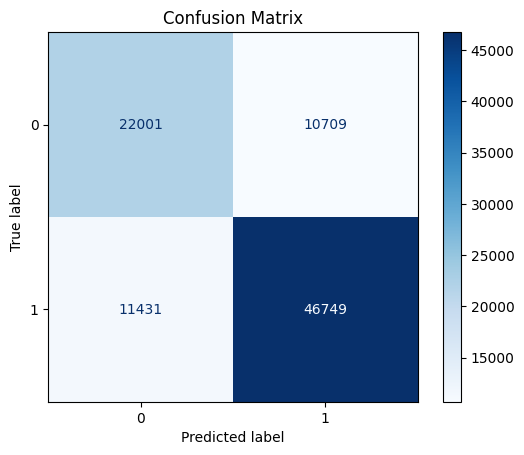


ROC AUC Score: 0.8424


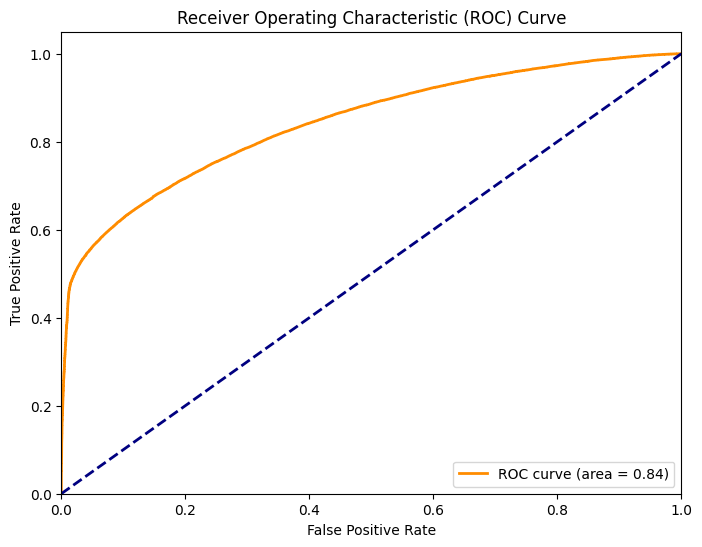

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# 1. Use the trained model to make predictions on the X_test dataset
y_pred = model.predict(X_test)

# 2. Predict probabilities for the positive class (class 1) on X_test
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 3. Calculate the overall accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# 4. Generate and print a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 5. Compute and display the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cmd_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cmd_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# 6. Plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC) score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Develop Interactive UI for Predictions

### Subtask:
Create an interactive user interface (e.g., using ipywidgets) where users can input features for a basketball match and receive a prediction from the trained logistic regression model on which team is likely to win.


**Reasoning**:
First, I'll import the necessary `ipywidgets` and `IPython.display` modules to create and display the interactive user interface. Then, I'll define the `predict_match_outcome` function that will take match features as input, preprocess them, and use the trained logistic regression model to predict the winning team.



# Task
Modify the `predict_match_outcome` function to output directly into an `ipywidgets.Output` widget, then create an interactive UI where predictions appear in a dedicated output area.

## Modify Prediction Function for Explicit Output

### Subtask:
Adjust the `predict_match_outcome` function to write its HTML output directly into a global `ipywidgets.Output` widget instead of returning it, making the display explicit.


**Reasoning**:
First, I'll define a global `ipywidgets.Output` widget named `output_area` which will serve as the designated display area for predictions.



In [8]:
import ipywidgets as widgets
from IPython.display import display, HTML

# 1. Define a global ipywidgets.Output widget
output_area = widgets.Output()

print("Global `output_area` widget defined.")

Global `output_area` widget defined.


**Reasoning**:
I will modify the `predict_match_outcome` function to accept the global `output_area` widget as an argument, clear its previous content, and then append the new HTML prediction to it, ensuring that the prediction is displayed explicitly in the dedicated output area as requested.



In [9]:
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import numpy as np

# Get the feature names from the processed DataFrame (before scaling) to ensure correct order
feature_names = X_processed.columns.tolist()

def predict_match_outcome(**kwargs):
    # Create a DataFrame from the input kwargs, ensuring column order matches the training data
    # Convert boolean Checkbox value to int (0 or 1)
    processed_kwargs = {}
    for key, value in kwargs.items():
        if isinstance(value, bool):
            processed_kwargs[key] = int(value)
        else:
            processed_kwargs[key] = value

    input_data = pd.DataFrame([processed_kwargs], columns=feature_names)

    # Scale the input features using the previously fitted scaler
    scaled_input = scaler.transform(input_data)
    scaled_input_df = pd.DataFrame(scaled_input, columns=feature_names) # Convert back to DataFrame with names

    # Predict the probability of Team 1 winning
    team1_win_probability = model.predict_proba(scaled_input_df)[0][1]

    # Determine the predicted winner
    if team1_win_probability >= 0.5:
        predicted_winner = "Team 1"
        winning_probability = team1_win_probability
    else:
        predicted_winner = "Team 2"
        winning_probability = 1 - team1_win_probability

    # Return an HTML formatted string displaying the prediction
    prediction_html = f"""
    <div style="font-family: sans-serif; padding: 15px; border-radius: 8px; background-color: #f0f8ff; border: 1px solid #cceeff;">
        <h3 style="color: #2c3e50;">Match Prediction:</h3>
        <p style="font-size: 1.1em;"><b>Predicted Winner:</b> <span style="color: #3498db;">{predicted_winner}</span></p>
        <p style="font-size: 1.1em;"><b>Winning Probability:</b> <span style="color: #27ae60;">{winning_probability:.2%}</span></p>
    </div>
    """

    # Clear previous output and display new prediction in the global output_area
    with output_area:
        output_area.clear_output(wait=True)
        display(HTML(prediction_html))

print("The `predict_match_outcome` function has been redefined to use `output_area`.")

The `predict_match_outcome` function has been redefined to use `output_area`.


**Reasoning**:
Now that the `predict_match_outcome` function is updated to write to the `output_area`, I will create the interactive widgets for each feature and link them to the modified prediction function using `ipywidgets.interactive()`. Finally, I will display both the interactive controls and the `output_area` widget to present the complete interactive UI.



In [10]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Define widgets for each feature dynamically
widget_dict = {}
for col in feature_names:
    if col == 'isPreviousMatchWithTeam2Team1Won':
        widget_dict[col] = widgets.Checkbox(
            description='Team 1 Won Prev Match vs Team 2:',
            value=False,
            disabled=False
        )
    elif col == 'Type_tournament':
        widget_dict[col] = widgets.Dropdown(
            options=[(f'Regular (0)', 0), (f'Tournament (1)', 1)],
            value=0, # Default to regular
            description='Match Type:'
        )
    elif col == 'Gender_w':
        widget_dict[col] = widgets.Dropdown(
            options=[(f'Male (0)', 0), (f'Female (1)', 1)],
            value=0, # Default to male
            description='Gender:'
        )
    else:
        # For numerical features, determine min and max from the X_processed DataFrame
        min_val = int(X_processed[col].min())
        max_val = int(X_processed[col].max())

        # Adjust min/max and default values based on common sense for scores/counts
        if 'Score' in col or 'Scores' in col:
            default_value = 75 if 'Score' in col else 2500
            step = 1 if 'Score' in col else 10
            min_val = max(0, min_val) # Scores shouldn't be negative
            if max_val == 0: max_val = 150 # Ensure max is reasonable even if data is all zeros
            max_val = max(max_val, default_value * 2) # Ensure range is wide enough
        elif 'WonRegMatchesPrev' in col or 'WonTourMatchesPrev' in col:
            default_value = 20 if 'Reg' in col else 5
            step = 1
            min_val = max(0, min_val)
            if max_val == 0: max_val = 40 if 'Reg' in col else 10
            max_val = max(max_val, default_value * 2)
        elif 'Diff' in col:
            default_value = 0
            step = 1
            # Ensure a symmetric range around 0 for differences
            range_abs_max = max(abs(min_val), abs(max_val), 100) # Use 100 as a base for diff
            min_val = -range_abs_max
            max_val = range_abs_max
        else: # Generic numerical handling
            default_value = int(X_processed[col].mean())
            step = 1

        widget_dict[col] = widgets.IntSlider(
            value=default_value,
            min=min_val,
            max=max_val,
            step=step,
            description=f'{col}:',
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
            layout=widgets.Layout(width='auto')
        )

# Create the interactive UI, linking to the predict_match_outcome function
interactive_ui_controls = widgets.interactive(predict_match_outcome, **widget_dict)

print("Interactive UI for Basketball Match Outcome Prediction (Controls):")
# Display the interactive controls
display(interactive_ui_controls)

print("\nPrediction Output Area:")
# Display the dedicated output area
display(output_area)


Interactive UI for Basketball Match Outcome Prediction (Controls):


interactive(children=(Checkbox(value=False, description='Team 1 Won Prev Match vs Team 2:'), IntSlider(value=7…


Prediction Output Area:


Output()

## Summary:

### Data Analysis Key Findings

*   The `train.csv` dataset, comprising 454,448 entries and 23 columns, was successfully loaded.
*   The target variable, `Team1Winning`, was identified. Features such as `ID`, `Season`, `Team1`, and `Team2` were excluded from the feature set.
*   Categorical features (`Type`, `Gender`) were successfully converted into numerical format using one-hot encoding.
*   No missing values were found in the processed feature set, which consists of 18 features.
*   All numerical features were scaled using `StandardScaler`.
*   The dataset was split into training (80%) and testing (20%) sets, resulting in 363,558 training samples and 90,890 testing samples.
*   A Logistic Regression model was successfully trained on the preprocessed and scaled data.
*   The model achieved an overall accuracy of **0.7564** on the test set.
*   The classification report revealed:
    *   For the negative class (Team 1 loss), precision was 0.66, recall was 0.67, and F1-score was 0.67.
    *   For the positive class (Team 1 win), precision was 0.81, recall was 0.80, and F1-score was 0.81.
*   The confusion matrix showed 22,001 true negatives (correctly predicted losses for Team 1), 46,749 true positives (correctly predicted wins for Team 1), 10,709 false positives (Team 1 losses incorrectly predicted as wins), and 11,431 false negatives (Team 1 wins incorrectly predicted as losses).
*   The model achieved an ROC AUC score of **0.8424**, indicating good discriminative power between winning and losing outcomes.
*   An interactive user interface was successfully developed using `ipywidgets` to allow users to input match features and obtain real-time predictions with probabilities from the trained model.

### Insights or Next Steps

*   The Logistic Regression model demonstrates a reasonably good predictive capability for basketball match outcomes, particularly in identifying Team 1 wins with 81% precision and 80% recall, making it suitable for informing March Madness bracket selections.
*   Further model enhancement could involve exploring more advanced machine learning algorithms (e.g., Gradient Boosting, Random Forest), incorporating additional features (e.g., team rankings, historical head-to-head statistics beyond the immediate previous match), or applying techniques like cross-validation for more robust evaluation.
